In [1]:
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
Pkg.update("Knet")
using Base.Iterators: flatten
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data
using FileIO;
using Images;
using Plots;
using TestImages;
using ImageView;
using Colors;
using Knet;
#import Knet:minibatch

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %>  ]  93.0 % Resolving package versions...
 Installed Crayons ─ v3.0.0
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [a8cc5b0e] ↑ Crayons v2.0.0 ⇒ v3.0.0


┌ Info: Recompiling stale cache file /home/ege/.julia/compiled/v1.0/Knet/f4vSz.ji for Knet [1902f260-5fb4-5aff-8c31-6271790ab950]
└ @ Base loading.jl:1190


In [ ]:
#https://github.com/denizyuret/Knet.jl/blob/master/data/mnist.jl (mnist)
#https://github.com/denizyuret/Knet.jl/blob/master/src/data.jl (minibatch)

In [64]:
data_path="proccessed_data_train"
folders=readdir(data_path)
println(folders)
class_number=size(folders,1)

["Angry", "Disgusted", "Fear", "Happy", "Sad", "Suprised"]


6

In [69]:
function read_data(data_path)
i=1
first_r=true
y=[]
x=0
for class in folders
    println("Class number ",i)
    directory=string(data_path,"/",class)
    for img in readdir(directory)
        arr_img=load(string(directory,"/",img))
        arr_img=channelview(arr_img)
        #arr_img=Gray.(arr_img)
        arr_img=convert(Array{Float32},arr_img)
        arr_img=reshape(arr_img,(72,72,3,1))
        label=zeros(size(folders))
        label[i]=1
        if first_r==false
            x=cat(arr_img,x,dims=4)
        else
            #global x=cat(arr_img,dims=4)
            x=cat(arr_img,dims=4)
        end
        push!(y,i)
        first_r=false
    end
    i+=1
    end
println(size(y))
println(size(x))
return x,y;
end

read_data (generic function with 2 methods)

In [70]:
train_x,train_y=read_data("proccessed_data_train");
test_x,test_y=read_data("proccessed_data_test");

Class number 1
Class number 2
Class number 3
Class number 4
Class number 5
Class number 6
(165,)
(72, 72, 3, 165)
Class number 1
Class number 2
Class number 3
Class number 4
Class number 5
Class number 6
(18,)
(72, 72, 3, 18)


In [73]:
batch_train=Knet.minibatch(train_x,train_y,10,xtype=Array{Float32},ytype=Array{Int32});
batch_test=Knet.minibatch(test_x,test_y,10,xtype=Array{Float32},ytype=Array{Int32});

In [22]:
function random_predict(class_number)
    index=rand(1:class_number)
    predict=zeros(class_number)
    predict[index]=1
    predict
end

random_predict (generic function with 1 method)

In [31]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p),padding=1) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [32]:
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [33]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [34]:
# For running experiments
function trainresults(model,dtrn,dtst,ep,optimizer,learning_r)
    train_iter(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
                
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in train_iter(length(dtrn), progress(optimizer(model,repeat(dtrn,ep),lr=learning_r))))
        r = reshape(collect(Float32,flatten(r)),(4,:))          
    return r
end

trainresults (generic function with 1 method)

In [38]:
base_model =   Chain(Conv(3,3,3,3), 
                Dense(36*36*3,class_number,identity))

Chain((Conv(P(Array{Float32,4}(3,3,3,3)), P(Array{Float32,4}(1,1,3,1)), Knet.relu, 0), Dense(P(Array{Float32,2}(6,3888)), P(Array{Float32,1}(6)), identity, 0)))

In [74]:
ep=20
base_model_plot=trainresults(base_model,batch_train,batch_test,ep,sgd,0.1)

1.98e+00  100.00%┣███████████████████████┫ 320/320 [03:28/03:28, 1.54i/s]


4×20 Array{Float32,2}:
 1.85729  1.79623  1.79303  1.79093  …  1.78929  1.78933  1.78936
 1.561    1.72868  1.74234  1.75389     1.80574  1.8064   1.80692
 0.83125  0.81875  0.81875  0.81875     0.825    0.825    0.825  
 0.7      0.7      0.7      1.0         1.0      1.0      1.0    

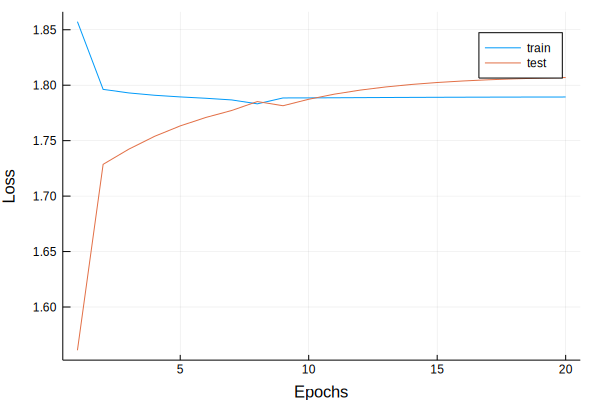

In [75]:
plot([base_model_plot[1,:], base_model_plot[2,:]],
     labels=[:train :test],xlabel="Epochs",ylabel="Loss")

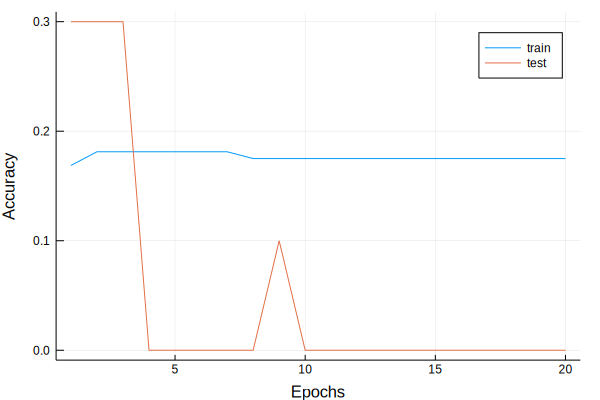

In [76]:
accuracy_trn=ones(size(base_model_plot[3,:]))-base_model_plot[3,:]
accuracy_tst=ones(size(base_model_plot[4,:]))-base_model_plot[4,:]
plot([accuracy_trn,accuracy_tst],
     labels=[:train :test],xlabel="Epochs",ylabel="Accuracy")